In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# RDKit installation

In [2]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [3]:
condacolab.check()

✨🍰✨ Everything looks OK!


In [4]:
!conda install -c conda-forge rdkit

Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - failed with initial frozen solve. Retrying with flexible solve.
Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | 

# RDKit load

In [5]:
import rdkit
import rdkit.Chem

# Extract specific SMILES and data (absorption max)

In [7]:
from tqdm import tqdm

smiles = []
abs_max_list = []

for l in tqdm(open("DB for chromophore_Sci_Data_rev02.csv").readlines()[1:]):
  dat = l.strip().split(',')
  if dat[2]=='ClCCl' and dat[3]!='NaN':     # select the cases where solvent is dichloromethane
    smiles.append(dat[1])
    abs_max_list.append(float(dat[3]))

print()
print(f"Number of SMILES strings: {len(smiles)}")
print(f"Number of Abs_Max: {len(abs_max_list)}")

100%|██████████| 20236/20236 [00:00<00:00, 555096.60it/s]


Number of SMILES strings: 2429
Number of Abs_Max: 2429


# Transform SMILES to MACCS Key representation for organic compounds

Reference: https://chem.libretexts.org/Courses/Intercollegiate_Courses/Cheminformatics/06%3A_Molecular_Similarity/6.01%3A_Molecular_Descriptors  

The MACCS (Molecular ACCess System) keys [17,18] are one of the most commonly used structural keys. They are sometimes referred to as the MDL keys, named after the company that developed them [the MDL Information Systems (now BIOVIA)]. While there are two sets of MACCS keys (one with 960 keys and the other containing a subset of 166 keys), only the shorter fragment definitions are available to the public. These 166 public keys are implemented in popular open-source cheminformatics software packages, including RDKit [20], OpenBabel [21,22], CDK [23,24], etc. The fragment definitions for the MACCS 166 keys can be found in this document:

https://github.com/rdkit/rdkit/blob/master/rdkit/Chem/MACCSkeys.py

In [8]:
from rdkit.Chem import MACCSkeys

# SMILES -> Mol-type example
mol = rdkit.Chem.MolFromSmiles(smiles[0])

# Mol-type -> MACCS key
vec = MACCSkeys.GenMACCSKeys(mol)

In [9]:
# BitVect object -> list
vec_list = vec.ToList()
print(len(vec_list)), print(vec_list)

167
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0]


(None, None)

In [10]:
# generate MACCS keys from SMILES for all species
X_raw = []
for smi in tqdm(smiles):
  vec = MACCSkeys.GenMACCSKeys(rdkit.Chem.MolFromSmiles(smi))
  X_raw.append(vec.ToList())

100%|██████████| 2429/2429 [00:10<00:00, 222.43it/s]


# Maximum absorption wave length

In [11]:
import numpy as np

# normalization
y = np.array(abs_max_list)
y = (y - min(y)) / (max(y) - min(y))

# Split train/test sets

In [12]:
import sklearn
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=42)   # 80/20 train/test split

In [13]:
import torch
torch.manual_seed(1234)

# numpy array -> tensor
X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.Tensor(y_train)
y_test = torch.Tensor(y_test)

In [14]:
print(X_train.shape), print(y_train.shape)

torch.Size([1943, 167])
torch.Size([1943])


(None, None)

In [15]:
from torch.utils.data import TensorDataset, DataLoader

# TensorDataset
ds_train = TensorDataset(X_train, y_train)
ds_test = TensorDataset(X_test, y_test)

# DataLoader
loader_train = DataLoader(ds_train, batch_size=128, shuffle=True, drop_last=True)
loader_test = DataLoader(ds_test, batch_size=128, shuffle=False)

In [16]:
from torch import nn

# model
model = nn.Sequential(
    nn.Linear(167, 50),       # input_dim = 167
    nn.Tanh(),
    nn.Linear(50, 50),
    nn.Tanh(),
    nn.Linear(50, 50),
    nn.Tanh(),
    nn.Linear(50, 20),
    nn.Tanh(),
    nn.Linear(20, 1)          # final output_dim = 1
)
print(model)

Sequential(
  (0): Linear(in_features=167, out_features=50, bias=True)
  (1): Tanh()
  (2): Linear(in_features=50, out_features=50, bias=True)
  (3): Tanh()
  (4): Linear(in_features=50, out_features=50, bias=True)
  (5): Tanh()
  (6): Linear(in_features=50, out_features=20, bias=True)
  (7): Tanh()
  (8): Linear(in_features=20, out_features=1, bias=True)
)


In [17]:
from torch import optim

# loss function
loss_fn = nn.MSELoss()     # mean squared error as it's a regression problem

# optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-5)

In [18]:
def train(epoch):
  loss_list = []
  model.train()

  for data, targets in loader_train:
    optimizer.zero_grad()
    outputs = model(data)

    loss = loss_fn(outputs, targets)
    loss_list.append(loss.item())
    loss.backward()
    optimizer.step()

  print(f"epoch {epoch} // Loss: {loss}")
  return loss_list

In [19]:
def test():
  model.eval()
  mse = 0

  with torch.no_grad():
    for data, targets in loader_test:
      outputs = model(data)

      mse += torch.sum((outputs - targets)**2)

  mse /= len(loader_test.dataset)
  mse = torch.sqrt(mse)

  print(f'\n prediction accuracy with the test data: {mse:.3f} // {mse*max(y):.3f}')

In [20]:
test() # test accuracy without training the model


 prediction accuracy with the test data: 5.379 // 5.379


In [21]:
for epoch in range(100):
  train(epoch)

test()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0 // Loss: 0.07806308567523956
epoch 1 // Loss: 0.042753707617521286
epoch 2 // Loss: 0.03331497311592102
epoch 3 // Loss: 0.026812534779310226
epoch 4 // Loss: 0.027133284136652946
epoch 5 // Loss: 0.032206665724515915
epoch 6 // Loss: 0.030630318447947502
epoch 7 // Loss: 0.031211765483021736
epoch 8 // Loss: 0.026428531855344772
epoch 9 // Loss: 0.038605496287345886
epoch 10 // Loss: 0.03551992028951645
epoch 11 // Loss: 0.0323885902762413
epoch 12 // Loss: 0.02619417943060398
epoch 13 // Loss: 0.032969310879707336
epoch 14 // Loss: 0.027089498937129974
epoch 15 // Loss: 0.02908879704773426
epoch 16 // Loss: 0.024596642702817917
epoch 17 // Loss: 0.02853621169924736
epoch 18 // Loss: 0.03721868246793747
epoch 19 // Loss: 0.035751305520534515
epoch 20 // Loss: 0.029736265540122986
epoch 21 // Loss: 0.034877970814704895
epoch 22 // Loss: 0.035538122057914734
epoch 23 // Loss: 0.025774117559194565
epoch 24 // Loss: 0.034249451011419296
epoch 25 // Loss: 0.03360163792967796
epoch 

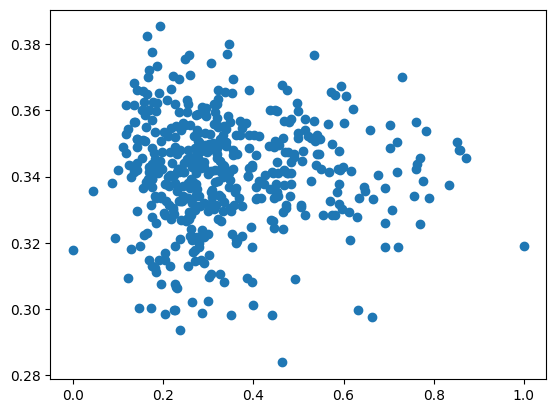

In [23]:
import matplotlib.pyplot as plt

outputs = model(X_test)
outputs = outputs[:,0]
outputs.shape
preds = outputs.detach().numpy()
y_true = y_test.detach().numpy()

plt.scatter(y_true, preds);

# Calculation of correlation coefficient

In [24]:
import numpy as np
np.corrcoef(preds, y_true)

array([[1.        , 0.00598153],
       [0.00598153, 1.        ]])

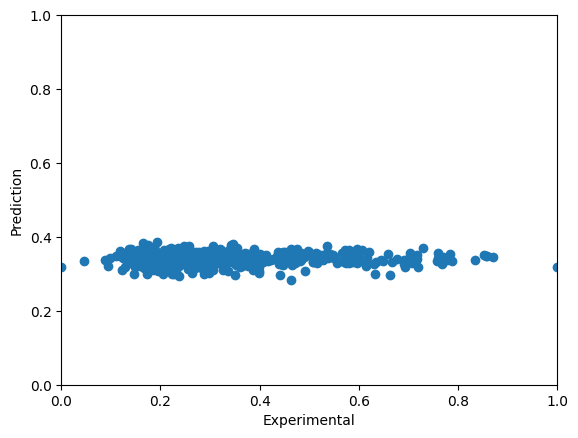

In [25]:
plt.xlim(0, 1.0)
plt.ylim(0, 1)
plt.xlabel('Experimental')
plt.ylabel('Prediction')
plt.scatter(y_true, preds);